<a href="https://colab.research.google.com/github/cyrus2281/notes/blob/main/MachineLearning/PyTorch/LazyProgrammer/02_PyTorch_Advanced_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content

>[Content](#scrollTo=KK6FzBGvITph)

>[Natural Language Processing](#scrollTo=PViL3CNyIerk)

>>[Text Preprocessing](#scrollTo=5kATizpXOkEX)

>>[Text Classification](#scrollTo=mIwD1WwCR7lz)



# Natural Language Processing

## Text Preprocessing

In [ ]:
!pip install torchtext==0.6.0

In [3]:
import torch
import torch.nn as nn
import torchtext.data as ttd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
# Let's make some fake data!
data = {
    "label": [0, 1, 1],
    "data":[
        "I like eggs and ham.",
        "Eggs I like!",
        "Ham and eggs or just ham?",
    ]
}

In [5]:
df = pd.DataFrame(data)
df.head()

,label,data
0,0,I like eggs and ham.
1,1,Eggs I like!
2,1,Ham and eggs or just ham?


In [6]:
df.to_csv('thedata.csv', index=False)

In [24]:
TEXT = ttd.Field(
    sequential=True,
    batch_first=True,
    lower=True,
    pad_first=True)
LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

# Note: if you don't specify use_vocab=False, then PyTorch will
# complain later when you try to iterate over the dataset that
# the attribute `vocab` doesn't exist.

# Note2: if you don't specify is_target=True, then PyTorch will
# assume it's part of the input, so when you iterate over the dataset
# it will be like: for (inputs, targets), _ in iterator:
# where the 2nd element (_) should have been the target.

dataset = ttd.TabularDataset(
    path='thedata.csv',
    format='csv',
    skip_header=True,
    fields=[('label', LABEL), ('data', TEXT)]
)

In [25]:
ex = dataset.examples[0]

In [28]:
type(ex), ex.data, ex.label

(torchtext.data.example.Example, ['i', 'like', 'eggs', 'and', 'ham.'], '0')

In [29]:
train_dataset, test_dataset = dataset.split(0.66) # default is 0.7

In [30]:
TEXT.build_vocab(train_dataset,)

In [31]:
vocab = TEXT.vocab
type(vocab)

torchtext.vocab.Vocab

In [32]:
vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7e08de40b0a0>>,
            {'<unk>': 0,
             '<pad>': 1,
             'eggs': 2,
             'and': 3,
             'ham': 4,
             'ham?': 5,
             'i': 6,
             'just': 7,
             'like!': 8,
             'or': 9})

In [33]:
vocab.itos

['<unk>', '<pad>', 'eggs', 'and', 'ham', 'ham?', 'i', 'just', 'like!', 'or']

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset, test_dataset), sort_key=lambda x : len(x.data),
    batch_sizes=(2,2), device=device)

In [20]:
for inputs, targets in train_iter:
  print("inputs:", inputs, "shape:", inputs.shape)
  print("targets:", targets, "shpape:", targets.shape)

inputs: tensor([[1, 1, 1, 2, 6, 8],
        [4, 3, 2, 9, 7, 5]], device='cuda:0') shape: torch.Size([2, 6])
targets: tensor([1, 1], device='cuda:0') shpape: torch.Size([2])


In [21]:
for inputs, targets in test_iter:
  print("inputs:", inputs, "shape:", inputs.shape)
  print("targets:", targets, "shpape:", targets.shape)

inputs: tensor([[6, 0, 2, 3, 0]], device='cuda:0') shape: torch.Size([1, 5])
targets: tensor([0], device='cuda:0') shpape: torch.Size([1])


## Text Classification

In [35]:
import torch
import torch.nn as nn
import torchtext.data as ttd
from torchtext.vocab import GloVe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [36]:
# Unfortunately this URL doesn't work directly with pd.read_csv
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2023-12-31 05:10:57--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  1.30MB/s    in 0.4s    

2023-12-31 05:10:59 (1.30 MB/s) - ‘spam.csv’ saved [503663/503663]



In [37]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

# rename columns to something better
df.columns = ['labels', 'data']

df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [38]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

df2 = df[['data', 'b_labels']]

df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [39]:
df2.to_csv('spam2.csv', index=False)

In [40]:
TEXT = ttd.Field(
    sequential=True,
    batch_first=True,
    lower=False,
    pad_first=True)
LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

# Note: if you don't specify use_vocab=False, then PyTorch will
# complain later when you try to iterate over the dataset that
# the attribute `vocab` doesn't exist.

# Note 2: if you don't specify is_target=True, then PyTorch will
# assume it's part of the input, so when you iterate over the
# dataset it will be like:
# for (inputs, targets), _ in iterator:
# where the 2nd element (_) should have been the target.

dataset = ttd.TabularDataset(
    path='spam2.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
)

In [41]:
train_dataset, test_dataset = dataset.split() # default is 0.7

In [42]:
TEXT.build_vocab(train_dataset,)

In [50]:
vocab = TEXT.vocab

vocab.itos[:5], vocab.stoi['you']

(['<unk>', '<pad>', 'to', 'you', 'I'], 3)

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [52]:
train_iter, test_iter = ttd.Iterator.splits(
        (train_dataset, test_dataset), sort_key=lambda x: len(x.data),
        batch_sizes=(32, 256), device=device)

In [53]:
for inputs, targets in train_iter:
  print("inputs:", inputs, "shape:", inputs.shape)
  print("targets:", targets, "shape:", targets.shape)
  break

inputs: tensor([[    1,     1,     1,  ..., 12288,  2521,  2981],
        [    1,     1,     1,  ...,     4,    31,    44],
        [    1,     1,     1,  ...,   103,   675,   197],
        ...,
        [    1,     1,     1,  ...,   293,   562,  4851],
        [    4,  1160,   101,  ...,    14,   387,  1074],
        [    1,     1,     1,  ...,     3,   452,  1705]], device='cuda:0') shape: torch.Size([32, 36])
targets: tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0') shape: torch.Size([32])


In [54]:
for inputs, targets in test_iter:
  print("inputs:", inputs)
  print("targets:", targets)
  break

inputs: tensor([[  201,    68,    23,   138,     8,   385],
        [ 2351,    36,     0,    29,    51,   623],
        [  263,   107,    74,    43,  2869, 10142],
        ...,
        [    1,     1,     1,     1,     1,  6738],
        [    1,     1,     1,     1,     1,     0],
        [    1,     1,     1,     1,     1,   129]], device='cuda:0')
targets: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


In [55]:
# Define the model
class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.embed = nn.Embedding(self.V, self.D)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # embedding layer
    # turns word indexes into word vectors
    out = self.embed(X)

    # get RNN unit output
    out, _ = self.rnn(out, (h0, c0))

    # max pool
    out, _ = torch.max(out, 1)

    # we only want h(T) at the final time step
    out = self.fc(out)
    return out

In [56]:
model = RNN(len(vocab), 20, 15, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(12402, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [57]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [58]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_iter:
      # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
      targets = targets.view(-1, 1).float()
      # move data to GPU
      # inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    test_loss = []
    for inputs, targets in test_iter:
      # inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')

  return train_losses, test_losses

In [59]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_iter, test_iter, 15)

Epoch 1/15, Train Loss: 0.4723,       Test Loss: 0.4185, Duration: 0:00:01.765047
Epoch 2/15, Train Loss: 0.3636,       Test Loss: 0.4095, Duration: 0:00:00.370674
Epoch 3/15, Train Loss: 0.3015,       Test Loss: 0.3722, Duration: 0:00:00.383863
Epoch 4/15, Train Loss: 0.2161,       Test Loss: 0.3498, Duration: 0:00:00.390218
Epoch 5/15, Train Loss: 0.1595,       Test Loss: 0.3124, Duration: 0:00:00.386197
Epoch 6/15, Train Loss: 0.1158,       Test Loss: 0.2723, Duration: 0:00:00.377194
Epoch 7/15, Train Loss: 0.0895,       Test Loss: 0.2532, Duration: 0:00:00.396085
Epoch 8/15, Train Loss: 0.0707,       Test Loss: 0.2245, Duration: 0:00:00.374977
Epoch 9/15, Train Loss: 0.0578,       Test Loss: 0.1987, Duration: 0:00:00.402898
Epoch 10/15, Train Loss: 0.0496,       Test Loss: 0.2030, Duration: 0:00:00.383157
Epoch 11/15, Train Loss: 0.0399,       Test Loss: 0.2251, Duration: 0:00:00.386496
Epoch 12/15, Train Loss: 0.0351,       Test Loss: 0.1894, Duration: 0:00:00.382659
Epoch 13/15, 

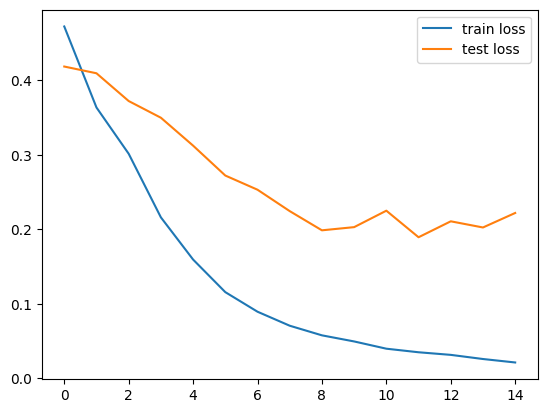

In [60]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [61]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_iter:
  targets = targets.view(-1, 1).float()

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_iter:
  targets = targets.view(-1, 1).float()

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9972, Test acc: 0.9091
